In [0]:
import tensorflow as tf
import numpy as np

# Build the outermost model

### A BatchNorm->Relu Block

In [0]:
def _br():
  def f(inputs):
    bn = tf.keras.layers.BatchNormalization(axis=-1)(inputs)
    relu = tf.keras.layers.Activation('relu')(bn)

    return relu

  return f

### A conv->bn->relu Block

In [0]:
def _cbr(filters,kernel_size=3,strides=1):
   
  def f(inputs):
    conv2d = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                    strides=strides,padding='same',
                                    use_bias=False, kernel_initializer='he_normal',
                                    #kernel_regularizer=tf.keras.regularizers.l2(5e-4)
                                    )(inputs)
  
    br = _br()(conv2d)

    return br
  return f

### Building a block according from the arctitecture given in how to train your resnet: baseline

In [0]:
def _block(filters,strides=1,first=False, scaledown=True):
  def f(inputs):
    x = inputs
    identity = x
    if(first == False):
      x = _br()(x)
    
    if(strides == 2 or scaledown==False):
      identity = tf.keras.layers.Conv2D(filters=filters,kernel_size=1,strides=strides,
                                        use_bias=False,kernel_initializer='he_normal',
                                        #kernel_regularizer=tf.keras.regularizers.l2(5e-4)
                                         )(identity)
      identity = tf.keras.layers.BatchNormalization(axis=-1)(identity)
      #identity = _cbr(filters,kernel_size=1,strides=strides)(identity)
    
    # Create a branch as follows: conv1->bn->relu->conv2 and add x + conv2
    x = _cbr(filters,strides=strides)(x)
    x = tf.keras.layers.Conv2D(filters=filters,kernel_size=3,
                               strides=1,padding='same',use_bias=False,
                               kernel_initializer='he_normal',
                               #kernel_regularizer=tf.keras.regularizers.l2(5e-4),
                               )(x)
    
    # Now addition operation
    x = tf.keras.layers.add([identity,x])

    return x
  return f

### This is the block mention in the Identity importance Paper

In [0]:
def _res_block(filters,strides=1):

  def f(inputs):
    identity = inputs
    x = inputs
    if strides==2:
      #identity = tf.keras.layers.Conv2D(filters,kernel_size=1,strides=2,
      #                                  using_bias=False,kernel_initializer=False)(identity)
      identity = _cbr(filters,kernel_size=1,strides=2)(identity)

    x = _cbr(filters,strides=strides)(x)
    x = _cbr(filters,strides=1)(x)

    x = tf.keras.layers.add([identity,x])

    return x
  return f

### Build a layer from the resnet 18 model

In [0]:
def _layer(filters,first=False,scaledown=True):

  def f(inputs):
    # Create two blocks 
    strides = 2
    if(scaledown == False):
      strides=1
    block_1 = _block(filters=filters,strides=strides, scaledown=scaledown)(inputs)
    block_2 = _block(filters=filters,strides=1, scaledown=scaledown)(block_1)

    return block_2
  
  return f


### Now build the complete Resnet18 Model

In [0]:
def Resnet18():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  conv_7x7 = tf.keras.layers.Conv2D(filters=64,kernel_size=7,strides=1, padding='same')(inputs)
  layer_1 = _layer(filters=64,first=True,scaledown=False)(conv_7x7)
  layer_2 = _layer(filters=128)(layer_1)
  # The scaledown exists beacuse, the size of input image is reducing way too fast
  layer_3 = _layer(filters=256, scaledown=True)(layer_2)
  layer_4 = _layer(filters=512, scaledown=False)(layer_3)
  avg = tf.keras.layers.GlobalAveragePooling2D()(layer_4)
  #conv_8x8 = tf.keras.layers.Conv2D(10,8,1)(layer_4)
  #flatten = tf.keras.layers.Flatten()(conv_8x8)
  outputs = tf.keras.layers.Dense(10,activation='softmax')(avg)
  
  model = tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [0]:
# Now test it on some random image
img = np.random.uniform(0,1,size=(1,32,32,3)).astype('float32')
print(img.shape)
model = Resnet18()
model.summary()

(1, 32, 32, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]       

# Training the Resnet 18 for CIFAR 10 for 300 epochs

### Prepare the data set
Augement the dataset as the input type must be uint8

In [0]:
BATCH_SIZE = 128
(X_train,y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train /= 255.0
X_test /= 255.0
mean,std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
#mean, std = X_train.mean(axis=(0,1,2)), X_train.std(axis=(0,1,2))

X_train = (X_train-mean)/std
X_test = (X_test - mean)/std


y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
# Pad 4px and Crop to 32,32


170500096/170498071 [==============================] - 13s 0us/step


In [0]:
def random_erasing(img):
  global mean
  r = np.random.randint(0,2)
  if(r == 0):
    return img
  h = np.random.randint(img.shape[0]//3,img.shape[0]//2)
  w = np.random.randint(img.shape[1]//3,img.shape[1]//2)

  x = np.random.randint(0,img.shape[0]//2)
  y = np.random.randint(0,img.shape[1]//2)

  img[x:x+h,y:y+h,:] = mean

  return img

In [0]:

def pad_and_crop(img):
  if(np.random.randint(0,2) == 0):
    return img
  img =  np.pad(img,((4,4),(4,4),(0,0)),mode='constant')
  x,y = np.random.randint(0,4), np.random.randint(0,4)
  img = img[x:x+32,y:y+32,:]
  return img


In [0]:
def horizontal_flip(img):
  if(np.random.randint(0,2) == 0):
    return img
  return np.flip(img,[1])

In [0]:
def data_aug(img):
  img = pad_and_crop(img)
  img = random_erasing(img)
  #img = horizontal_flip(img)
  return img

In [0]:
## Image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
#    preprocessing_function=pad_and_crop_ra,
    horizontal_flip=True,
)
#
for i in range(len(X_train)):
  print(f"\rAugmention Image:{i}/{len(X_train)}", end=" ")
  X_train[i] = data_aug(X_train[i])
train_data = train_datagen.flow(X_train,y_train,batch_size=BATCH_SIZE,)
test_data = ImageDataGenerator().flow(X_test,y_test,batch_size=BATCH_SIZE)


Augmention Image:49999/50000 

### Using Cyclic LR

In [0]:
!rm -rf DLlib
!git clone "https://github.com/RaghavendraGaleppa/DLlib"

Cloning into 'DLlib'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 144 (delta 66), reused 115 (delta 39), pack-reused 0
Receiving objects: 100% (144/144), 24.41 KiB | 127.00 KiB/s, done.
Resolving deltas: 100% (66/66), done.


In [0]:
import DLlib as d
from tensorflow.keras.callbacks import *
step_size = 10
#iter_size = 100
iter_size = len(X_train)//BATCH_SIZE
epochs = 100

clr_triangular = d.utils.CyclicLR(base_lr=0.004,max_lr=0.1,step_size=2000)
sgdr = d.utils.SGDRestart(base_lr=0.004,max_lr=0.01,step_size=200)
cym = d.utils.CyclicMomentum(base_lr=0.9, max_lr=0.85, step_size=2000)

modelCheckpoint1 = tf.keras.callbacks.ModelCheckpoint('every_50',save_freq=390*50)
modelCheckpoint2 = tf.keras.callbacks.ModelCheckpoint('best_model',monitor='val_acc', save_best_only=True)

In [0]:
def weighted_loss(model,weight_decay):
  def custom_loss(y, y_pred):
    ''' A custom loss function to include weight decay '''
    loss = tf.keras.losses.categorical_crossentropy(y, y_pred)
    layers = [l for l in model.layers if type(l) == tf.keras.layers.Conv2D]
    total_loss = 0.0
    for l in layers:
      total_loss += tf.nn.l2_loss(l.trainable_weights[0])
    
    return loss + total_loss*weight_decay
  return custom_loss


### Train the model

In [18]:
model = Resnet18()
epochs=100
opt = tf.keras.optimizers.SGD(learning_rate=0.01,nesterov=True,momentum=0.9,decay=0)
model.compile(loss=weighted_loss(model, 5e-4),
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit_generator(train_data,steps_per_epoch=len(X_train)/BATCH_SIZE,
        epochs=epochs,validation_data=test_data,
        validation_steps=len(X_test)/BATCH_SIZE,
        callbacks=[clr_triangular]
)


Epoch 1/100
391/390 [==============================] - 92s 236ms/step - loss: 4.2325 - acc: 0.4236 - val_loss: 5.1117 - val_acc: 0.3484
Epoch 2/100
391/390 [==============================] - 85s 219ms/step - loss: 3.6099 - acc: 0.5850 - val_loss: 4.4376 - val_acc: 0.4568
Epoch 3/100
391/390 [==============================] - 87s 222ms/step - loss: 3.0916 - acc: 0.6609 - val_loss: 3.1311 - val_acc: 0.6321
Epoch 4/100
391/390 [==============================] - 87s 221ms/step - loss: 2.6014 - acc: 0.7075 - val_loss: 2.5676 - val_acc: 0.6880
Epoch 5/100
391/390 [==============================] - 87s 222ms/step - loss: 2.1528 - acc: 0.7367 - val_loss: 2.4463 - val_acc: 0.6639
Epoch 6/100
391/390 [==============================] - 87s 222ms/step - loss: 1.7438 - acc: 0.7709 - val_loss: 1.8140 - val_acc: 0.7248
Epoch 7/100
391/390 [==============================] - 87s 222ms/step - loss: 1.4164 - acc: 0.8130 - val_loss: 1.6138 - val_acc: 0.7635
Epoch 8/100
391/390 [===========================


### Plotting the history

In [19]:
len(train_data)

391

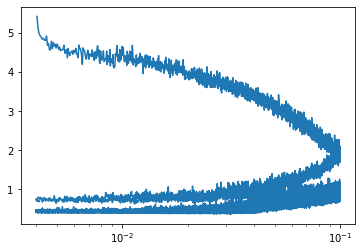

In [20]:
import matplotlib.pyplot as plt
plt.semilogx(clr_triangular.history['lr'], clr_triangular.history['loss'])

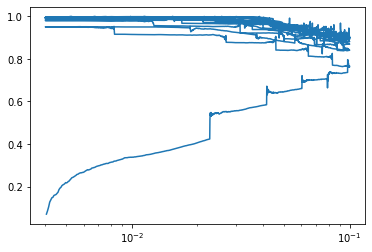

In [21]:
#plt.semilogx(clr_triangular.history['lr'], clr_triangular.history['loss'])
plt.semilogx(clr_triangular.history['lr'], clr_triangular.history['acc'])

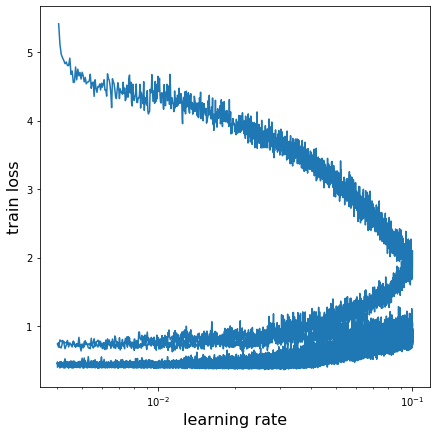

In [22]:
clr_triangular.plot_lr_loss(loss_threshold=20)

In [0]:
def plot_twin(lr,loss,acc):
  fig, ax1 = plt.subplots(figsize=(5,5))
  ax1.set_xlabel('lr', fontsize=16)
  ax1.set_ylabel('loss', fontsize=16)
  ax1.semilogx(lr,loss,c='r', label='loss')
  ax1.legend()

  ax2 = ax1.twinx()
  ax2.set_ylabel('acc', fontsize=16)
  ax2.semilogx(lr,acc,c='b',label='acc')
  ax2.legend()
  plt.show()


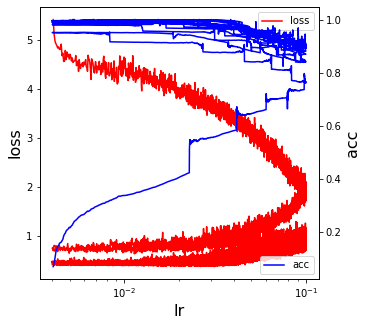

In [24]:
plot_twin(clr_triangular.history['lr'],
          clr_triangular.history['loss'],
          clr_triangular.history['acc'])